### 01_EDA

The purpose of this notebook is to perform Exploratory Data Analysis (EDA) on our dataset. We've previously loaded the first 100k entries from the `accepted_2007_to_2018Q4.csv.gz` file available [here](accepted_2007_to_2018Q4.csv.gz), from Kaggle's `All Lending Club loan data` dataset. 

The dataset includes various features related to loan aplications, along with the `loan_status` variable which, as expected, indicates the status of the loan. 

In this notebook we will begin visualizing some of the key relations within the data.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
con = duckdb.connect('data/processed/loans.duckdb')
df = con.execute('SELECT * FROM loans').df()
con.close()

In [3]:
print(df.shape)

(500000, 151)


#### 1. Class distribution

0.156056


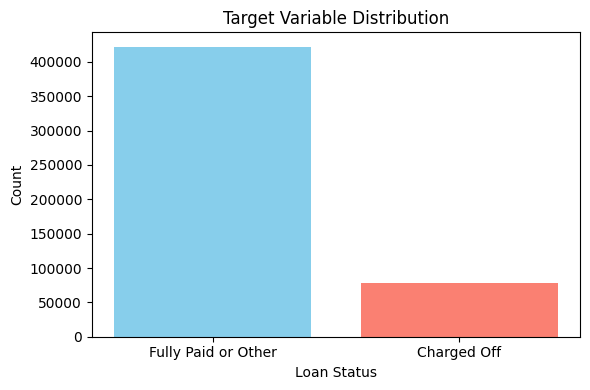

In [4]:
# variable distribution
df['target'] = df['loan_status'].eq('Charged Off').astype(int)
print(df['target'].mean())

class_counts = df['target'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(class_counts.index, class_counts.values, color=['skyblue','salmon'])
plt.xticks([0,1], ['Fully Paid or Other','Charged Off'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Target Variable Distribution')
plt.tight_layout()
plt.show()

We can see that our dataset has an imbalanced target distribution, with only 15.6% of samples belonging to the positive class.

#### 2. Default rate by year

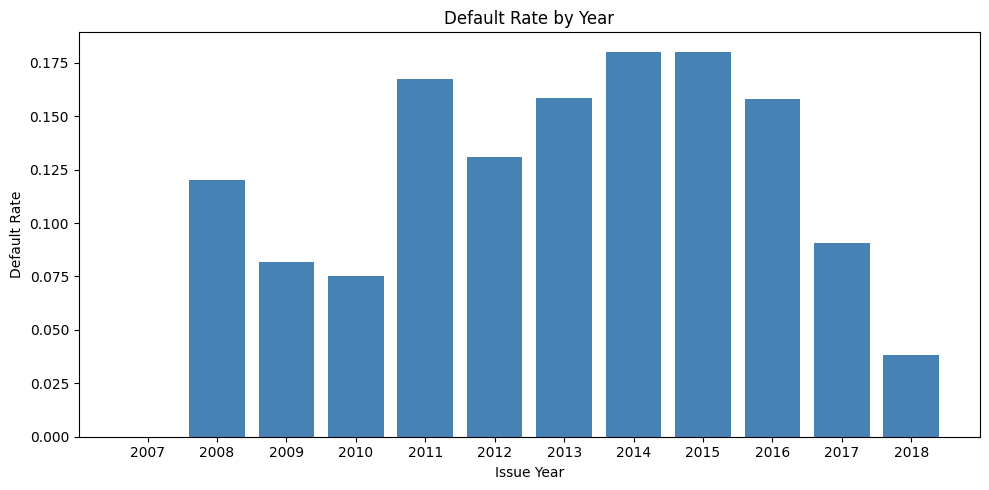

In [5]:
result = duckdb.query(
    """ 
    SELECT RIGHT(issue_d, 4) AS issue_year, AVG(target) AS default_rate
    FROM df
    GROUP BY issue_year
    ORDER BY issue_year
    """
).to_df()
result = result.dropna(subset=['issue_year'])

plt.figure(figsize=(10,5))
plt.bar(result['issue_year'], result['default_rate'], color='steelblue')
plt.xlabel('Issue Year')
plt.ylabel('Default Rate')
plt.title('Default Rate by Year')
plt.tight_layout()
plt.show()

We observe an interesting wave-like behavior on the default rate by year. The target rate declines for 2 consecutive years until 2010, then rises steadily, peaking around 2014/2015, after which another downwards trend follows. 

#### 3. Anual income histogram
Let's examine the annual income data distribution to check for outliers. Now, income is a tricky variable to visualize due to the extreme skewness it presents. The top 1%, for example, will make exponentially more money than the rest of the population. To address this, we will use 2 histograms, one to visualize the Log(1 + Annual Income) distribution using Numpy's  `log1p()` function. Then, we will use another chart to visualize the annual income distribution with values capped at 300,000 (a technique known as 'winsorizing').

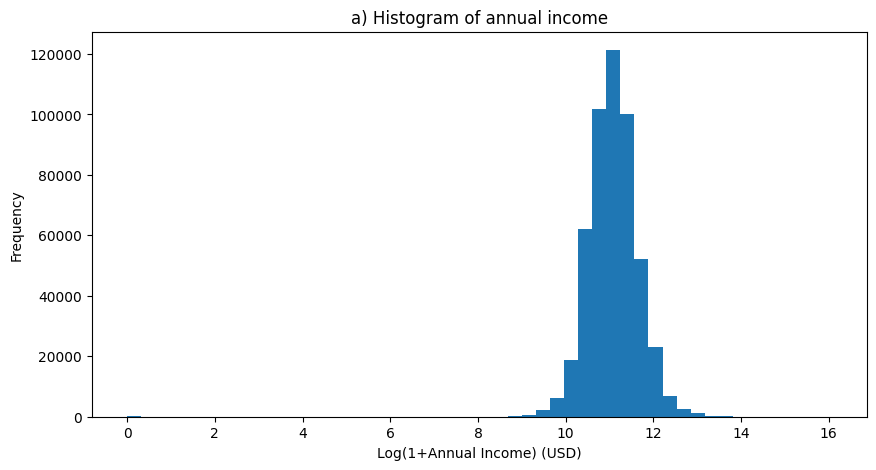

In [6]:
df['annual_inc'] = pd.to_numeric(df['annual_inc'], errors='coerce')

plt.figure(figsize=(10,5))
plt.hist(np.log1p(df['annual_inc'].dropna()), bins=50)
plt.title('a) Histogram of annual income')
plt.xlabel('Log(1+Annual Income) (USD)')
plt.ylabel('Frequency')
plt.show()

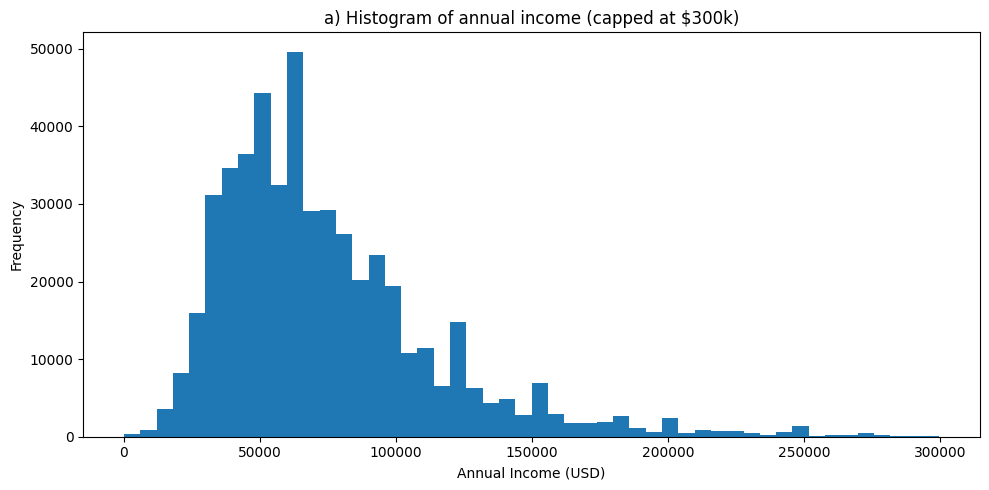

In [7]:
plt.figure(figsize=(10,5))
plt.hist(df[df['annual_inc']<300000]['annual_inc'].dropna(), bins=50)
plt.title('a) Histogram of annual income (capped at $300k)')
plt.xlabel('Annual Income (USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

We observe a bell-shaped curve (approximately Gaussean) distribution in the log-transformed annual income histogram, showing a better, more symmetric spread after transformation. Looking at the capped histogram, we can see that the annual income frequency of loaners peaks at about 50-70 thousand, then steadily decreases as income increases, indicating a right skewed distribution on the original scale.

#### 4. Interest rate histogram

Let's now analyze the interest rate distribution of the interest rates.

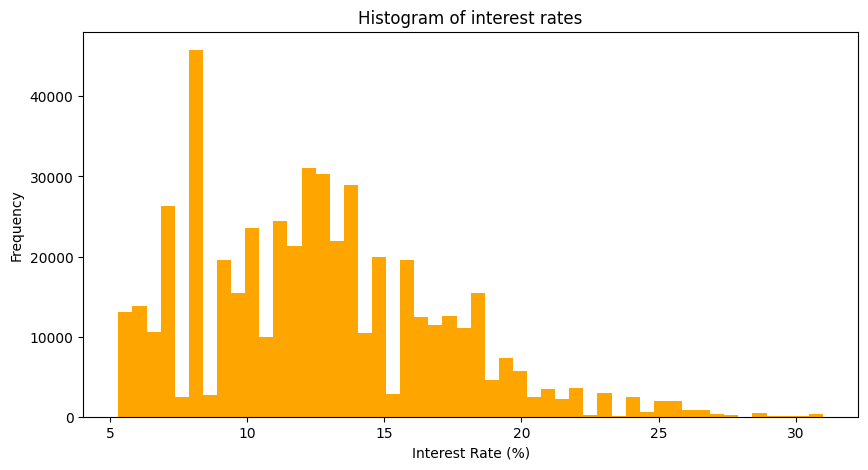

In [8]:
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

plt.figure(figsize=(10,5))
plt.hist(df['int_rate'].dropna(), bins=50, color='orange')
plt.title('Histogram of interest rates')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Frequency')
plt.show()

Looking at the interest rate distribution, we can observe a formation that loosely resembles a bell curve. The highest overall frequency occurs at around 8%, forming a clear spike at that value. There's also a secondary concentration of values between 12%-14%, contributing to the curve's shape. Overall, while the distribution is slightly right-skewed, the skeweness is not severe, and the variable appears suitable for modeling. 

#### 5. Missing values

Let's now employ a heatmap to visualize the distribution of missing values. This will help us decide if there are any variables that should be dropped or some other action must be taken. Since there are 151 columns in the dataset, we will focus only in columns with missing data.

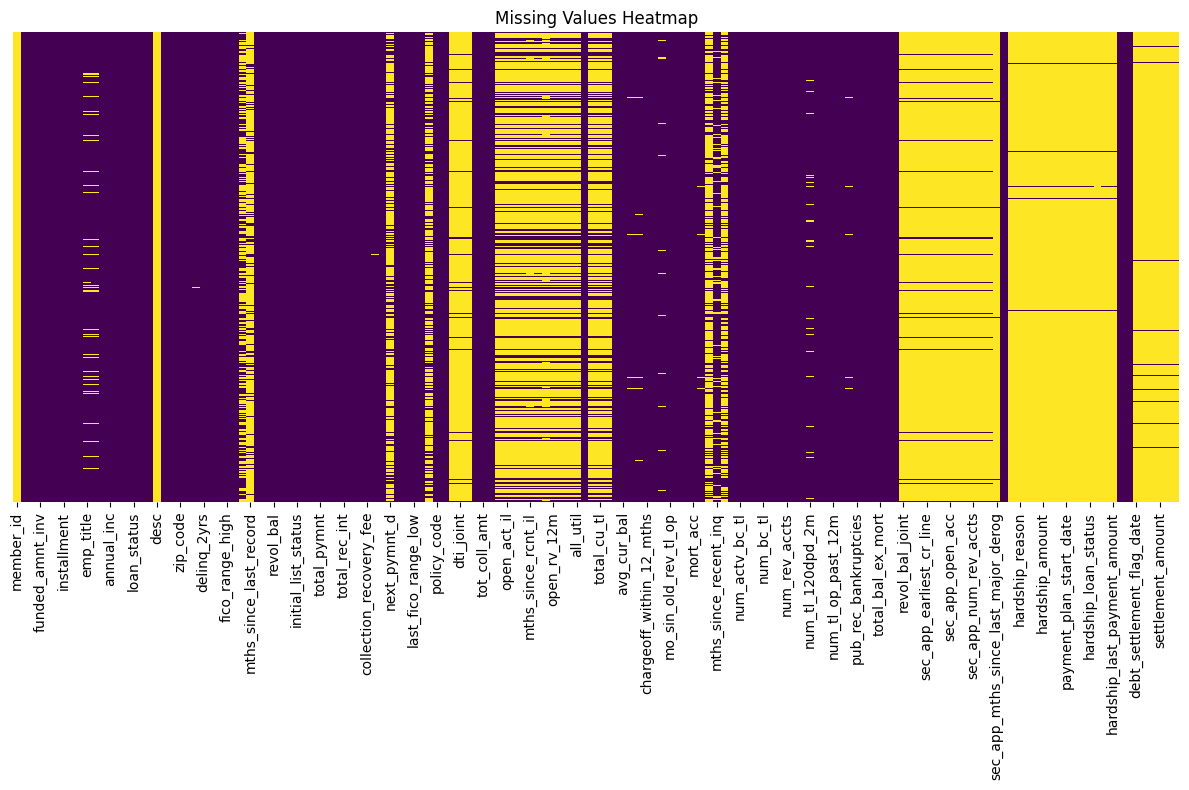

In [9]:
missing_cols = df.columns[df.isnull().any()]

plt.figure(figsize=(12,8))
sns.heatmap(df[missing_cols].isnull(),
            cbar=False,
            cmap='viridis',
            yticklabels=False)
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

This heatmap is quite insightful. The mostly purple columns represent the variables where there are just a couple of missing values. These can be handled by imputing or droping some rows. Those mostly yellow columns, however, represent those where most of the values are missing. Particularly, we will drop those columns where over more than 50% of the values are missing.

In [10]:
# top 20 columns with most missing values
missing_percent = df.isnull().mean().sort_values(ascending=False)*100
print(missing_percent[:60])
missing_over_50 = missing_percent[:58]

member_id                                     100.0000
desc                                           99.7484
orig_projected_additional_accrued_interest     99.5510
hardship_status                                99.4458
hardship_last_payment_amount                   99.4458
hardship_length                                99.4458
payment_plan_start_date                        99.4458
hardship_reason                                99.4458
deferral_term                                  99.4458
hardship_amount                                99.4458
hardship_end_date                              99.4458
hardship_start_date                            99.4458
hardship_loan_status                           99.4458
hardship_payoff_balance_amount                 99.4458
hardship_dpd                                   99.4458
hardship_type                                  99.4458
sec_app_mths_since_last_major_derog            99.1298
debt_settlement_flag_date                      97.6924
settlement

Based on the percentage of missing values on each variable, we will permanently drop all variables with 95% or more missing data. These features appear in only a small fraction of loan entries, and the cost-benefit tradeoff of including them in the model is unlikely to justify their use.

Variables with 50% to 94% missing data will be temporally excluded form the initial model. These variables, however, may still possess predictive value, so we are keeping them to experiment later in case the base model performance is unsatisfactory.

#### 6. Loan Purpose
Let's now examine the distribution of loan purposes. This way, we may visualize if distinct loan purposes behave differently. 

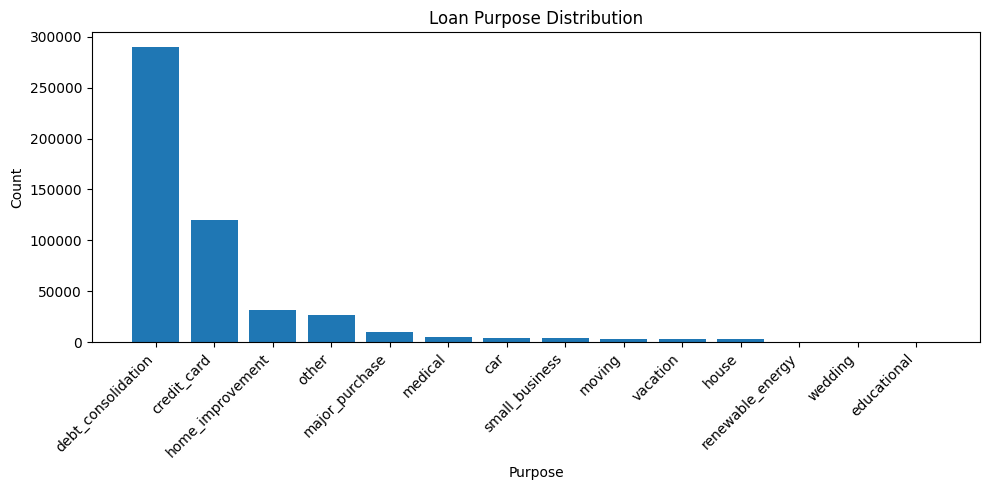

In [11]:
counts = df['purpose'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(counts.index, counts.values)
plt.title('Loan Purpose Distribution')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Debt consolidation** is by far the most common loan purpose in our sample. **Credit card**, **home improvement** and **other** also represent a significant count. In contrast, the remaining categories seem to contribute relatively little to the loan purpose count, including **medical**, which one might expect to be one of the major loan purposes.

Next, let's analyze the default rate by loan purpose.

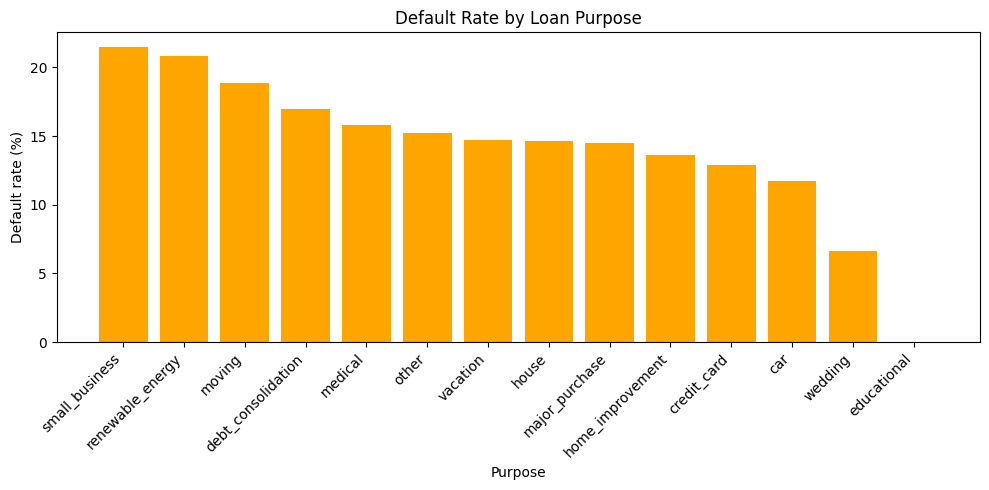

In [12]:
default_rate_by_purpose = df.groupby('purpose')['target'].mean().sort_values(ascending=False)*100

plt.figure(figsize=(10,5))
plt.bar(default_rate_by_purpose.index, default_rate_by_purpose.values, color='orange')
plt.title('Default Rate by Loan Purpose')
plt.xlabel('Purpose')
plt.ylabel('Default rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We observe that **small_business** and **renewable_energy** present the highest default rates, both being slightly above 20%. The default rate by purpose counts then seems to decrease, although the drop is relatively gradual, with most categories showing moderate variation on their default rates. 

The **Educational** category, however, shows a default rate of 0%, although this rate might not be as insighful as it seems, given the fact that our dataset, despite consisting of half a million records, contains only 9 loans where the loan purpose is **educational**. This sample size is too small to draw reliable conclusions, meaning we can likely dismiss this result as statistically insignificant.

#### 7. Default per grade

The **grade** variable represents the credit grade which indicates the credit risk level. **A** represents the best credit profile and lowest risk, while **G** represents the poorest credit profile and the highest risk. Let's now visualize the default rate per grade.

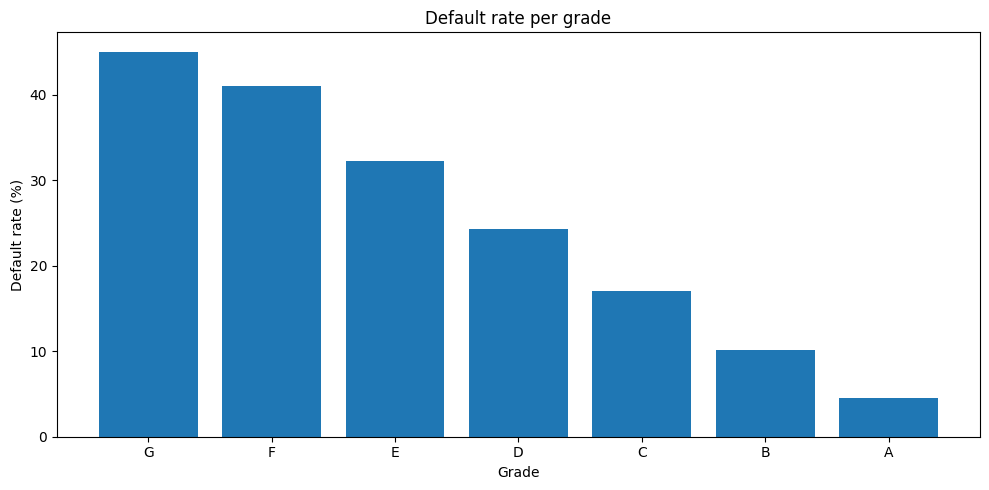

In [13]:
default_per_grade = df.groupby('grade')['target'].mean().sort_values(ascending=False)*100

plt.figure(figsize=(10,5))
plt.bar(default_per_grade.index, default_per_grade.values)
plt.title('Default rate per grade')
plt.xlabel('Grade')
plt.ylabel('Default rate (%)')
plt.tight_layout()
plt.show()

We observe **grade** is a strong predictor of default risk, with default rate increasing consistently from grade **A** to grade **G**. This variable will be among the most important to predict default rates in our model.